In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import torch
print(torch.__version__)

2.9.1+cu126


In [17]:
from nik_io import load_event
from nik_model import NIK_SIREN_REIM, NIK_SIREN_KXY_REIM
from nik_train import prepare_tensors, fit_one_frame_slice_coil, plot_measured_vs_pred_kspace
from nik_recon import ifft1d_kz_to_z, nufft2d_recon, make_fixed_frame_zslice_coil_dataset, split_points_by_spokes
import numpy as np
import random

In [18]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [19]:
# Load data with images
event = load_event("../XCAT-ERIC/results/simulation_results_20260115T150400.mat", load_images=True)

In [20]:
k_np, traj_np = event["k"], event["traj"]
gt_img = event.get("gt_img")  # Ground truth images
rc_img = event.get("rc_img")  # Reconstructed images from file

# Set in expected dimension order
k_np = np.transpose(k_np, (0, 2, 1, 3))
traj_np = np.transpose(traj_np, (0, 2, 1, 3))

T, S, C, RO = k_np.shape
print("k DCE shape : ", k_np.shape)
print("trajectory shape : ", traj_np.shape)

k_t, traj_t, scales, dims, k_scale = prepare_tensors(k_np, traj_np, data_device="cuda")

k DCE shape :  (60, 392, 8, 220)
trajectory shape :  (60, 392, 3, 220)


In [21]:
# Select parameters
t_frame = 0  # Which time frame to reconstruct
coil_idx = 0  # Which coil to use
n_steps = 750  # Training steps per slice
batch_size = 4096
lr = 1e-4

# iFFT kz -> z (interleaved spokes -> z slices)
k_img_space, n_z_slices, n_ro_per_slice, kz_sort_order = ifft1d_kz_to_z(k_t, traj_t, t_frame=t_frame)
print(f"Number of z slices: {n_z_slices}")
print(f"Readouts per slice: {n_ro_per_slice}")

Number of z slices: 7
Readouts per slice: 56


In [22]:
z_slice_idx = n_z_slices // 2  # Middle z-slice

x_all, y_all, kx_all, ky_all, spoke_id_all, ro_id_all, meta = make_fixed_frame_zslice_coil_dataset(
    k_img_space,
    traj_t,
    scales,
    dims,
    y_scale=k_scale,
    t_fixed=t_frame,
    coil_fixed=coil_idx,
    z_slice_idx=z_slice_idx,
    n_slices=n_z_slices,
    compute_device="cuda",
)
print(meta)

train_idx, val_idx, train_spokes, val_spokes = split_points_by_spokes(
    spoke_id_all, val_frac=0.2, seed=0, mode="random"
)

x_train, y_train = x_all[train_idx], y_all[train_idx]
x_val, y_val     = x_all[val_idx],   y_all[val_idx]

{'t_fixed': 0, 'coil_fixed': 0, 'z_slice_idx': 3, 'n_slices': 7, 'n_ro_per_slice': 56, 'N': 12320, 'y_scale': 42.8240852355957}


In [23]:
x_val

tensor([[-0.9320,  0.3624,  0.0000, -1.0000],
        [-0.9235,  0.3591,  0.0000, -1.0000],
        [-0.9150,  0.3558,  0.0000, -1.0000],
        ...,
        [-0.9799,  0.0607,  0.0000, -1.0000],
        [-0.9890,  0.0613,  0.0000, -1.0000],
        [-0.9981,  0.0618,  0.0000, -1.0000]], device='cuda:0')

In [24]:
# Automatically get image size from loaded data
if gt_img is not None:
    print(gt_img.shape)
    img_size = gt_img.shape[2:4]
elif rc_img is not None:
    print(rc_img.shape)
    img_size = rc_img.shape[2:4]
else:
    img_size = (128, 128)  # fallback
print(f"Using image size: {img_size}")


model = NIK_SIREN_KXY_REIM(k_freq=64,
        k_sigma=2.5,
        hidden=256,
        depth=7,
        w0=30)  


pred_imgs = []
pred_steps = []

def cb(step, model):
    with torch.no_grad():
        model.eval()

        coil_idx_all = torch.full((x_all.shape[0],), int(coil_idx), device=x_all.device, dtype=torch.long)

        if isinstance(model, NIK_SIREN_KXY_REIM): 
            y_pred_all = model(x_all[:, :2]) * k_scale
        else:
            y_pred_all = model(x_all, coil_idx_all) * k_scale
        
        k_pred = torch.complex(y_pred_all[:, 0], y_pred_all[:, 1]).reshape(n_ro_per_slice, RO)

        k_img_space_pred = torch.zeros_like(k_img_space)
        k_img_space_pred[t_frame, :, coil_idx, z_slice_idx, :] = k_pred

        img_pred = nufft2d_recon(
            k_img_space_pred, traj_t,
            t_frame=t_frame, coil_idx=coil_idx, z_slice_idx=z_slice_idx,
            scales=scales, img_size=img_size, n_slices=n_z_slices
        )

        pred_imgs.append(img_pred)
        pred_steps.append(step)

        model.train()



(121, 7, 220, 152)
Using image size: (220, 152)


In [25]:
model, info = fit_one_frame_slice_coil(
    model,
    x_all=x_all, y_all=y_all,
    steps=n_steps,
    batch_size=batch_size,
    lr=lr,
    amp=False,
    device="cuda",
    use_tqdm=True,
    callback=cb,
    callback_every=250,  # plot every 250 steps
)

Overfitting fixed (t,kz,coil): 100%|█| 750/750 [00:03<00:00, 239.08it/s, mse=1.3


In [26]:
t = t_frame
G = n_z_slices
S = traj_t.shape[1]

idx0 = torch.arange(0, S, G, device=traj_t.device)
idx1 = torch.arange(1, S, G, device=traj_t.device)

dkx = (traj_t[t, idx0, 0, :] - traj_t[t, idx1, 0, :]).abs().max().item()
dky = (traj_t[t, idx0, 1, :] - traj_t[t, idx1, 1, :]).abs().max().item()
print("max |Δkx|:", dkx, "max |Δky|:", dky)

max |Δkx|: 0.0 max |Δky|: 0.0


/home/rnga/vvpshenov/tmp/ipykernel_2593942/270346970.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


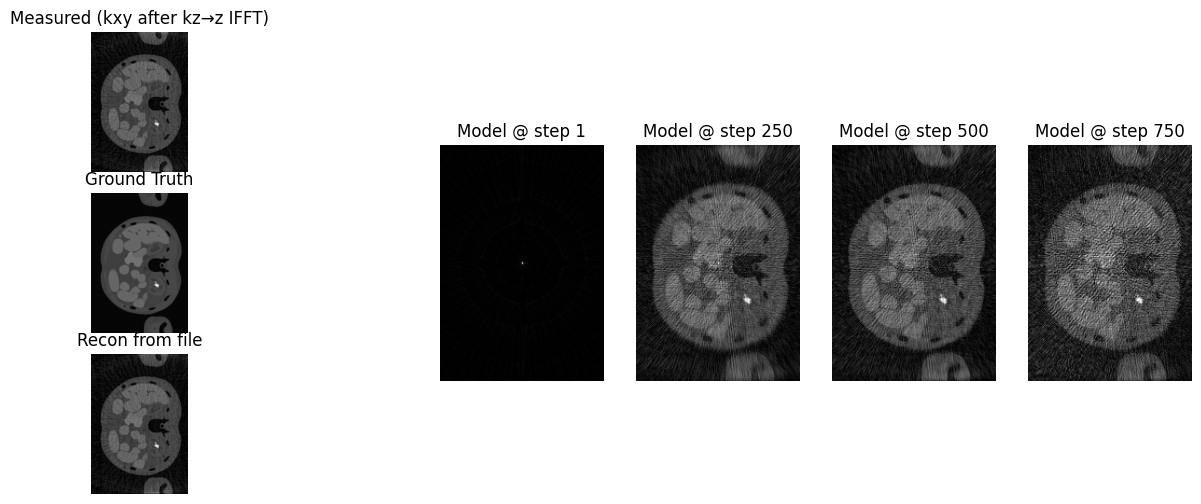

In [27]:
import math
import matplotlib.pyplot as plt

# --- left : fixed reference images ---
img_measured = nufft2d_recon(
    k_img_space, traj_t,
    t_frame=t_frame, coil_idx=coil_idx, z_slice_idx=z_slice_idx,
    scales=scales, img_size=img_size, n_slices=n_z_slices
)

img_gt_file = gt_img[t_frame, z_slice_idx, :, :] if gt_img is not None else None
img_recon_file = rc_img[t_frame, z_slice_idx, :, :] if rc_img is not None else None

n_preds = len(pred_imgs)
cols = min(4, n_preds) if n_preds > 0 else 1
rows = math.ceil(n_preds / cols) if n_preds > 0 else 1

fig = plt.figure(figsize=(16, max(6, 2.5 * rows)))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 2], wspace=0.2)

# Left: 3 stacked refs
gs_left = gs[0, 0].subgridspec(3, 1, hspace=0.15)
ax0 = fig.add_subplot(gs_left[0, 0])
ax0.imshow(img_measured, cmap="gray"); ax0.set_title("Measured (kxy after kz→z IFFT)"); ax0.axis("off")

ax1 = fig.add_subplot(gs_left[1, 0])
if img_gt_file is not None:
    ax1.imshow(img_gt_file, cmap="gray"); ax1.set_title("Ground Truth"); ax1.axis("off")
else:
    ax1.text(0.5, 0.5, "GT not available", ha="center", va="center"); ax1.axis("off")

ax2 = fig.add_subplot(gs_left[2, 0])
if img_recon_file is not None:
    ax2.imshow(img_recon_file, cmap="gray"); ax2.set_title("Recon from file"); ax2.axis("off")
else:
    ax2.text(0.5, 0.5, "Recon not available", ha="center", va="center"); ax2.axis("off")

# Right: prediction grid
gs_right = gs[0, 1].subgridspec(rows, cols, hspace=0.2, wspace=0.2)
for i in range(rows * cols):
    ax = fig.add_subplot(gs_right[i // cols, i % cols])
    if i < n_preds:
        ax.imshow(pred_imgs[i], cmap="gray")
        ax.set_title(f"Model @ step {pred_steps[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()



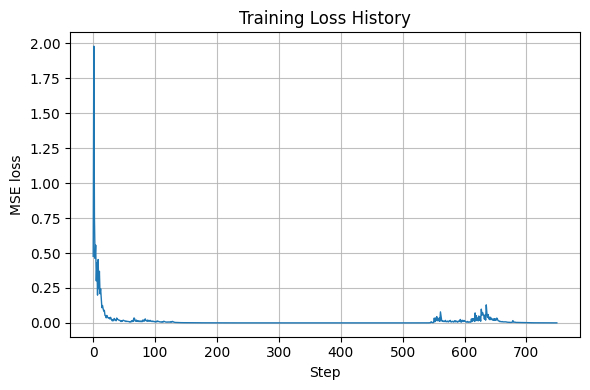

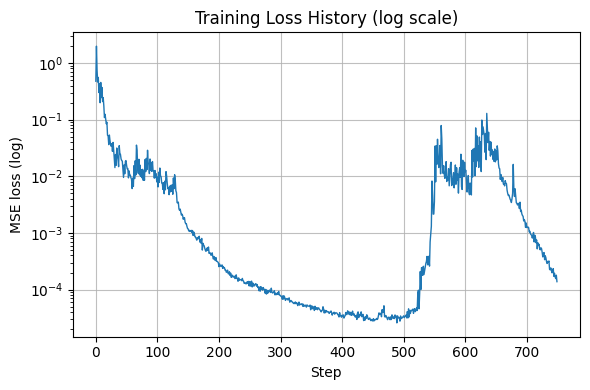

In [28]:
loss_hist = info["loss_hist"]

plt.figure(figsize=(6, 4))
plt.plot(loss_hist, lw=1)
plt.xlabel("Step")
plt.ylabel("MSE loss")
plt.title("Training Loss History")
plt.grid(True, alpha=0.8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.semilogy(loss_hist, lw=1)
plt.xlabel("Step")
plt.ylabel("MSE loss (log)")
plt.title("Training Loss History (log scale)")
plt.grid(True, alpha=0.8)
plt.tight_layout()
plt.show()